INDITEX METODO ARIMA

In [1]:
pip install pandas numpy matplotlib seaborn statsmodels pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Paso 1: Cargar y preparar los datos**




In [3]:
df = pd.read_csv("/content/IBEX35_cotizaciones_20_Limpio.csv", sep=",")
df

,Fecha,Empresa,Precio_cierre
0,NaN,NaN,NaN
1,2005-04-01,ACCIONA,36.337158
2,2005-04-04,ACCIONA,35.794037
3,2005-04-05,ACCIONA,36.233715
4,2005-04-06,ACCIONA,36.388882
...,...,...,...
151101,2025-03-26,UNICAJA BANCO,1.774000
151102,2025-03-27,UNICAJA BANCO,1.749000
151103,2025-03-28,UNICAJA BANCO,1.710000
151104,2025-03-31,UNICAJA BANCO,1.706000


In [4]:
df_inditex = df[df["Empresa"] == "INDITEX"]

In [5]:
df_inditex.to_csv('df_inditex2.csv', index=False)

In [6]:
df_inditex['Fecha'] = pd.to_datetime(df_inditex['Fecha'], errors='coerce')


<ipython-input-6-219087d9476c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inditex['Fecha'] = pd.to_datetime(df_inditex['Fecha'], errors='coerce')


In [7]:
#Seleccionar solo las columnas necesarias y establecer el índice
df_inditex = df_inditex[['Fecha', 'Precio_cierre']].set_index('Fecha')

In [8]:
df_inditex.isnull().sum()

,0
Precio_cierre,0


In [9]:
df_inditex

,Precio_cierre
Fecha,
2005-04-01,0.929286
2005-04-04,0.917765
2005-04-05,0.921738
2005-04-06,0.926902
2005-04-07,0.929683
...,...
2025-03-26,46.810001
2025-03-27,46.570000
2025-03-28,46.230000


** Paso 2: Visualizar la serie temporal**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

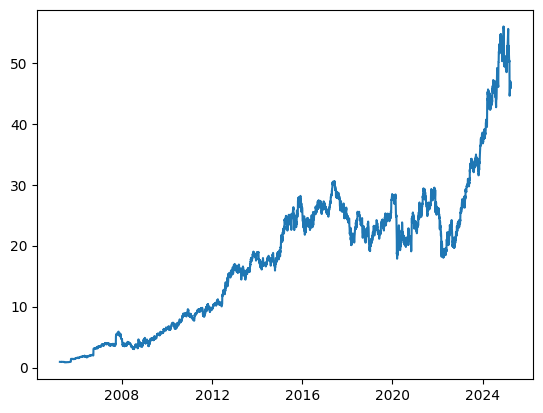

In [11]:
plt.plot(df_inditex)

**PASO 3: Descomposición de la serie para ver estacionalidad**

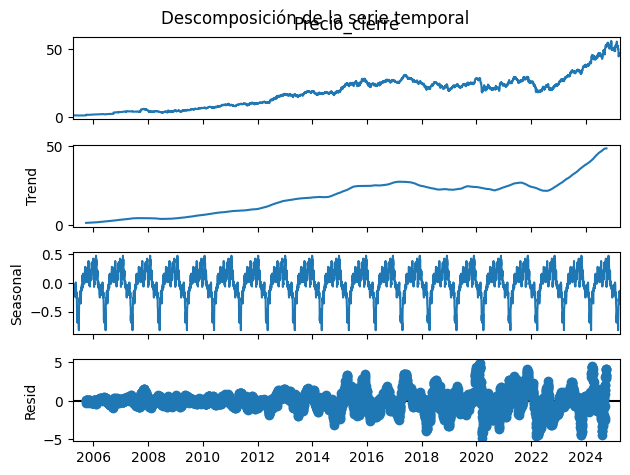

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición aditiva con frecuencia anual (252 días hábiles)
decomposicion = seasonal_decompose(df_inditex['Precio_cierre'], model='additive', period=252)

# Mostrar los componentes
decomposicion.plot()
plt.suptitle('Descomposición de la serie temporal')
plt.show()


**Paso 3: Comprobar si es estacionaria (ADF test)**

In [13]:
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(df_inditex["Precio_cierre"])
print("ADF Statistic:", resultado[0])
print("p-value:", resultado[1])


ADF Statistic: 0.3547854294439974
p-value: 0.9797230194201539


p-valor > 0.05 -> la serie NO es estacionaria -> necesita diferenciacion

**Paso 4: Diferenciación**

In [14]:
# NO sobrescribas la columna original
df_inditex["Close_diff"] = df_inditex["Precio_cierre"].diff()

# ADF sobre la serie diferenciada (sin nulos)
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_inditex["Close_diff"].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -13.99455315659654
p-value: 3.96115040595373e-26


In [15]:
df_inditex.dropna(inplace=True)

In [16]:
df_inditex

,Precio_cierre,Close_diff
Fecha,,
2005-04-04,0.917765,-0.011521
2005-04-05,0.921738,0.003973
2005-04-06,0.926902,0.005165
2005-04-07,0.929683,0.002781
2005-04-08,0.923326,-0.006357
...,...,...
2025-03-26,46.810001,0.380001
2025-03-27,46.570000,-0.240002
2025-03-28,46.230000,-0.340000


**PASO 6: Identificar parametros**

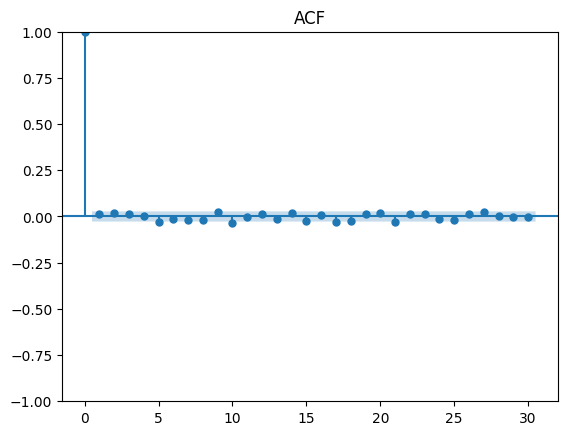

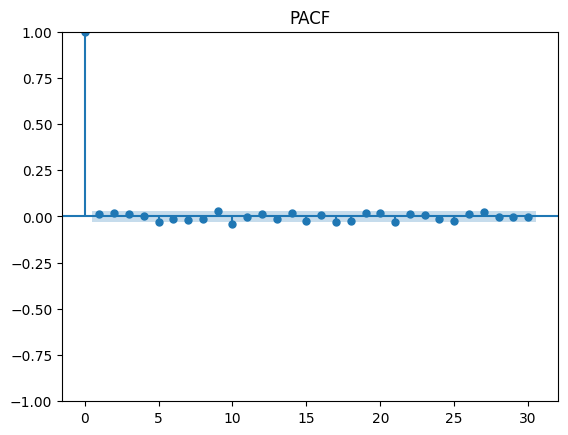

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF (para q)
plot_acf(df_inditex['Close_diff'].dropna(), lags=30)
plt.title("ACF")
plt.show()

# PACF (para p)
plot_pacf(df_inditex['Close_diff'].dropna(), lags=30)
plt.title("PACF")
plt.show()


Interpretación de los gráficos:
✅ ACF (Autocorrelación)
Solo hay un pico significativo en el lag 1.

Después, todos los valores están dentro del intervalo de confianza (zona azul).

➡️ Esto sugiere: q = 1

✅ PACF (Autocorrelación parcial)
También solo hay un pico claro en el lag 1.

El resto está dentro de los límites.

➡️ Esto sugiere: p = 1

📌 Conclusión: Modelo recomendado
Dado que has diferenciado una vez:

ini
Copiar código
order = (1, 1, 1)
Y como ya detectaste estacionalidad anual con period=252, puedes comenzar con:

ini
Copiar código
seasonal_order = (1, 1, 1, 252)

**PASO 7: AJUSTAR SARIMA**

In [18]:
# Fecha de corte
fecha_corte = '2022-04-01'

train = df_inditex.loc[:fecha_corte]['Precio_cierre']
test = df_inditex.loc[fecha_corte:]['Precio_cierre']


In [21]:
from pmdarima import auto_arima

modelo_auto = auto_arima(train,
                         seasonal=True,
                         m=5,  # frecuencia semanal laboral (ajustable)
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=1467.693, Time=10.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1472.147, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=1469.706, Time=0.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1469.707, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=1471.002, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=1466.544, Time=10.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=1464.462, Time=4.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=1467.245, Time=8.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=1471.693, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=1471.905, Time=2.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[5] intercept   : AIC=1466.199, Time=7.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[5] intercept   : AIC=1468.312, Time=5.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=1470.622, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[5] intercept   : AIC=1472.077, Time=6.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[5] intercept   : AIC=1472.367, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[5] intercept   : AIC=1469.514, Time=6.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[5]             : AIC=inf, Time=4.72 sec

Best model:  ARIMA(2,1,2)(0,0,0)[5] intercept
Total fit time: 72.006 seconds


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(train,
                 order=modelo_auto.order,
                 seasonal_order=modelo_auto.seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)

modelo_fit = modelo.fit()



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


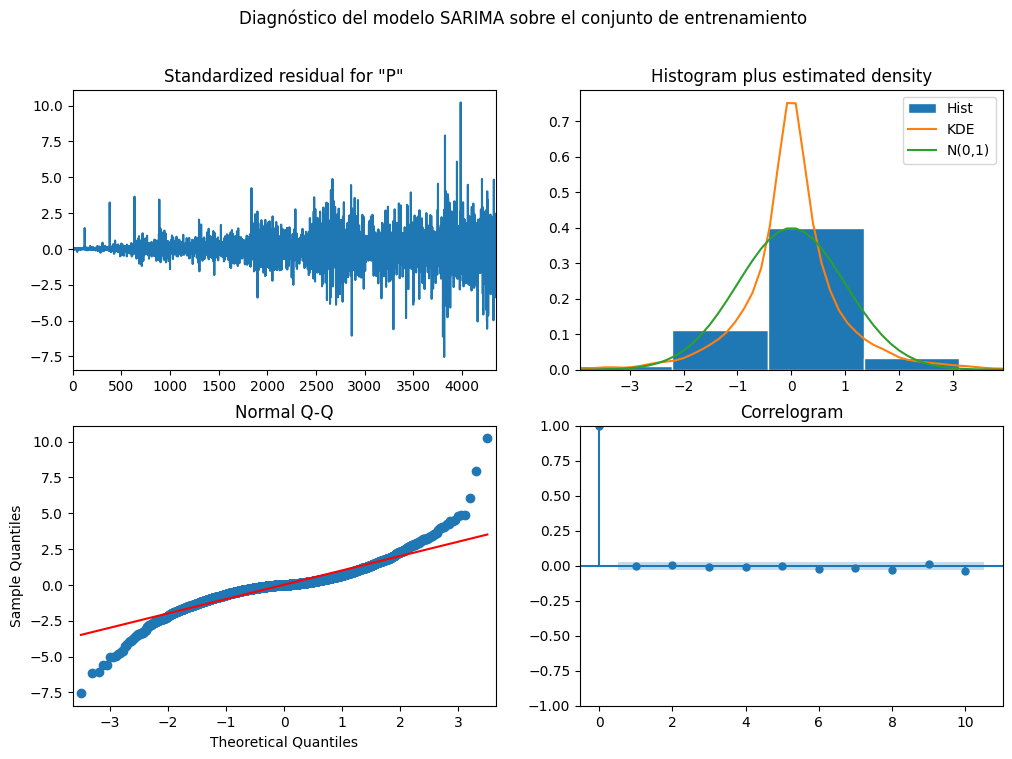

In [23]:
modelo_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('Diagnóstico del modelo SARIMA sobre el conjunto de entrenamiento')
plt.show()


In [24]:
# Número de pasos a predecir
n_periods = len(test)

# Predecir
forecast = modelo_fit.forecast(steps=n_periods)

# Alinear índices
forecast.index = test.index


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.4f}")


RMSE: 20.2600


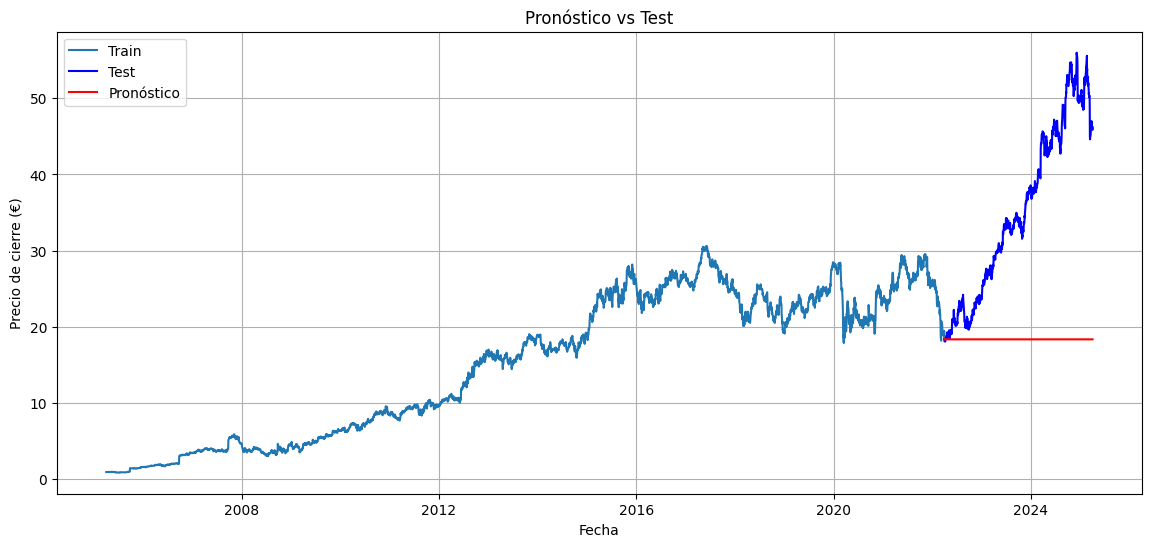

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Pronóstico', color='red')
plt.title('Pronóstico vs Test')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (€)')
plt.legend()
plt.grid(True)
plt.show()


INCLUIR T DE TENDENCIA PARA QUE NO SEA UNA LINEA RECTA

In [30]:
from pmdarima import auto_arima

modelo_auto = auto_arima(train,
                         seasonal=False,  # sin SARIMA
                         trend='t',       # incluye tendencia
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1471.382, Time=1.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1472.910, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1469.550, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1469.651, Time=3.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1472.910, Time=0.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1471.280, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1471.438, Time=1.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1478.912, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1469.550, Time=0.46 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 10.892 seconds


In [31]:
# 2. Ajuste SARIMAX con tendencia explícita
modelo = SARIMAX(train,
                 order=modelo_auto.order,
                 trend='t',  # ← incluye la tendencia lineal
                 enforce_stationarity=False,
                 enforce_invertibility=False)
modelo_fit = modelo.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


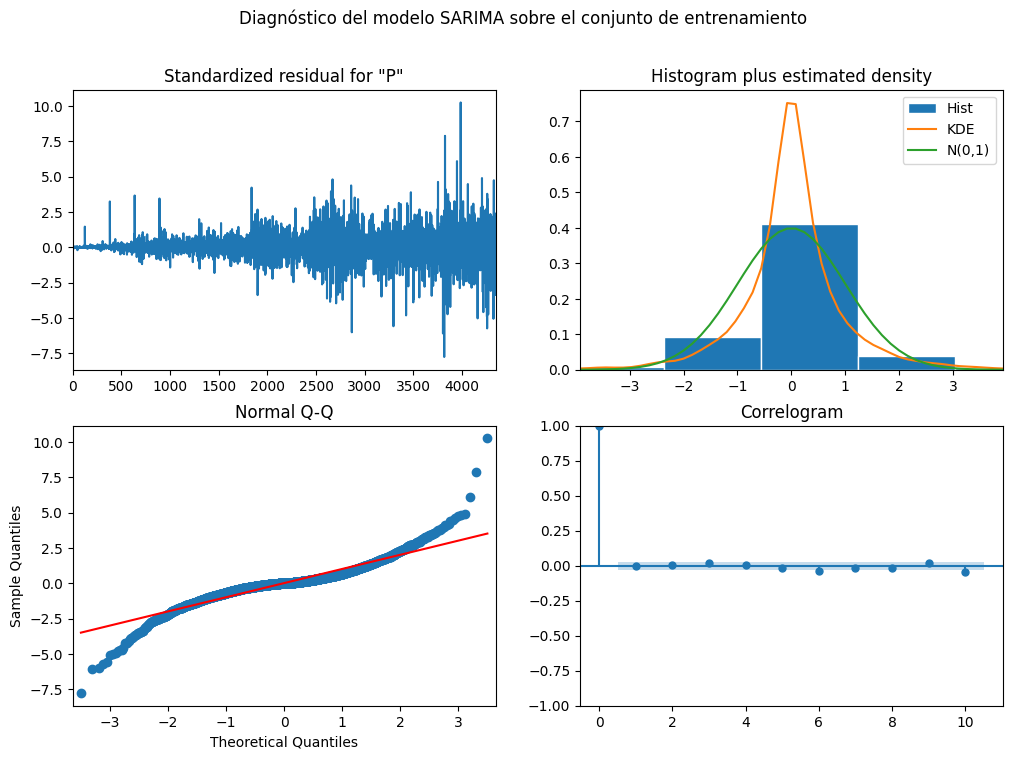

In [33]:
modelo_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('Diagnóstico del modelo SARIMA sobre el conjunto de entrenamiento')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


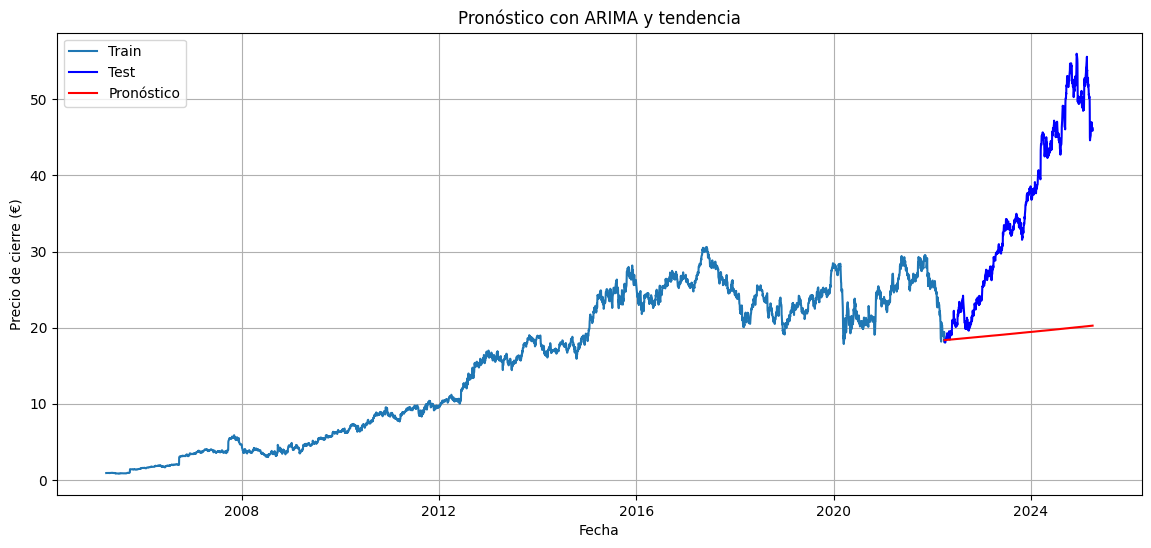

In [32]:
# 3. Forecast alineado al test
forecast = modelo_fit.forecast(steps=len(test))
forecast.index = test.index

plt.figure(figsize=(14, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Pronóstico', color='red')
plt.title('Pronóstico con ARIMA y tendencia')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (€)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Asegúrate de alinear los índices (ya lo hiciste)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.4f}")


RMSE: 19.1660


PRUEBA CON ESTACIONALIDAD MES BURSATIL

In [35]:
modelo_auto = auto_arima(train,
                         seasonal=True,
                         m=21,
                         stepwise=True,
                         trace=True,
                         suppress_warnings=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[21] intercept   : AIC=1460.975, Time=26.27 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=1472.147, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=1459.584, Time=2.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=1459.664, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=1471.002, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[21] intercept   : AIC=1468.732, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[21] intercept   : AIC=1461.542, Time=17.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[21] intercept   : AIC=1461.565, Time=6.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[21] intercept   : AIC=1459.578, Time=2.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[21] intercept   : AIC=1461.549, Time=9.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[21] intercept   : AIC=1463.565, Time=10.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[21] intercept   : AIC=1462.865, Time=2.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[21] intercept   : AIC=1461.366, Time=3.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[21] intercept   : AIC=1461.482, Time=3.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[21] intercept   : AIC=1462.954, Time=13.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[21]             : AIC=1458.605, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[21]             : AIC=1467.648, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[21]             : AIC=1460.589, Time=8.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[21]             : AIC=1460.568, Time=3.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[21]             : AIC=1458.604, Time=1.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[21]             : AIC=1460.570, Time=3.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[21]             : AIC=1462.571, Time=6.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[21]             : AIC=1461.798, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[21]             : AIC=1460.374, Time=1.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[21]             : AIC=1460.500, Time=1.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[21]             : AIC=1458.691, Time=1.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[21]             : AIC=1461.939, Time=9.10 sec

Best model:  ARIMA(1,1,0)(1,0,0)[21]          
Total fit time: 142.704 seconds


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(train,
                 order=modelo_auto.order,
                 seasonal_order=modelo_auto.seasonal_order,
                 trend='t',
                 enforce_stationarity=False,
                 enforce_invertibility=False)

modelo_fit = modelo.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


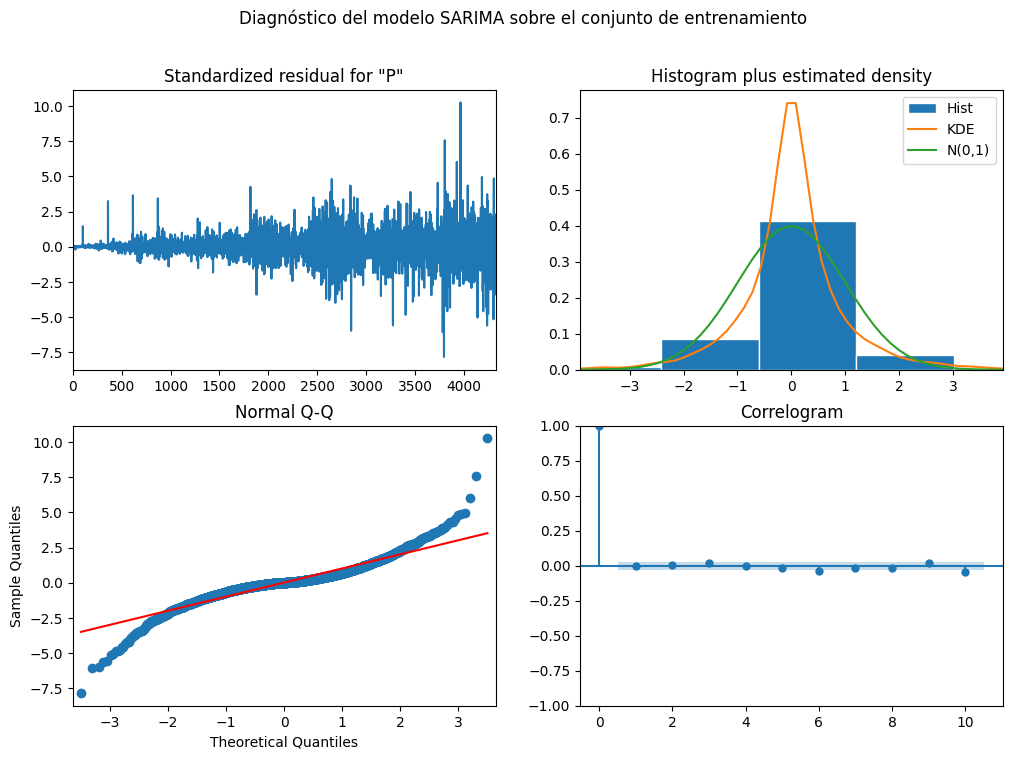

In [39]:
modelo_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('Diagnóstico del modelo SARIMA sobre el conjunto de entrenamiento')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


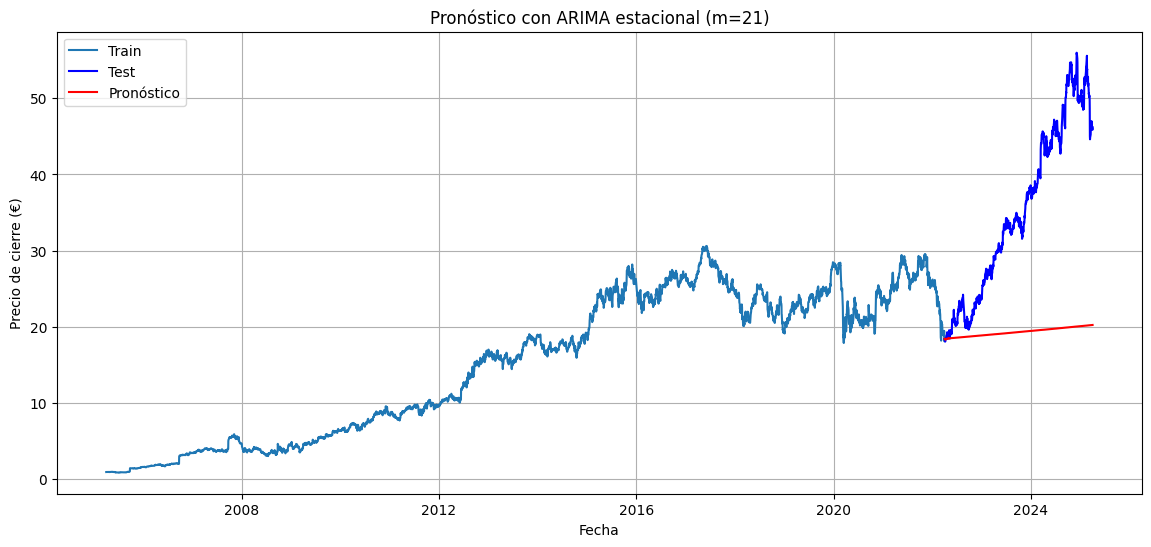

In [37]:
# Forecast para el periodo de test
forecast = modelo_fit.forecast(steps=len(test))
forecast.index = test.index  # muy importante

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Pronóstico', color='red')
plt.title('Pronóstico con ARIMA estacional (m=21)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (€)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.4f}")


RMSE: 19.1745
